In [5]:
import psycopg2
from psycopg2 import sql
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import cvxpy as cp

from util import *

In [6]:
problems_by_report = get_problem_data_by_report()

# Выводим результат
for report_id, problems in problems_by_report.items():
    print(f"\nОтчет #{report_id}:")
    for i, (name, freq) in enumerate(problems, 1):
        print(f"  {i}. {name} (частота: {freq})")

# Или в виде списка кортежей
problems_list = get_problem_data_as_list()
print(f'problems_list = {problems_list[1][1]}')
print("\nДанные в виде списка кортежей:")
for report_id, problems in problems_list:
    print(f"Отчет {report_id}: {len(problems)} проблем")


Отчет #1:
  1. Безработица (частота: 80)
  2. Дорожные пробки (частота: 200)
  3. Низкое качество образования (частота: 150)
  4. Коррупция в ЖКХ (частота: 96)
  5. Отсутствие детских садов (частота: 100)
  6. Загрязнение парков (частота: 330)

Отчет #2:
  1. Высокие тарифы ЖКХ (частота: 300)
  2. Недостаток больниц (частота: 491)
  3. Уличное воровство (частота: 73)
  4. Наркомания среди молодежи (частота: 90)
  5. Разрушение дорожного покрытия (частота: 427)
  6. Отсутствие спортивных площадок (частота: 212)
  7. Шумовое загрязнение ночью (частота: 346)
  8. Нехватка парковочных мест (частота: 452)
  9. Проблемы с общественным транспортом (частота: 500)
  10. Засилье рекламных конструкций (частота: 100)
problems_list = [('Высокие тарифы ЖКХ', 300), ('Недостаток больниц', 491), ('Уличное воровство', 73), ('Наркомания среди молодежи', 90), ('Разрушение дорожного покрытия', 427), ('Отсутствие спортивных площадок', 212), ('Шумовое загрязнение ночью', 346), ('Нехватка парковочных мест', 

In [7]:
budget_items = get_budget_items()

# Выводим результат
print(f"Получено {len(budget_items)} статей бюджета:")
for i, (name, min_budget) in enumerate(budget_items, 1):
    print(f"{i}. {name} (мин. бюджет: {min_budget:,.2f} руб.)")

# Пример использования вектора
print("\nВектор кортежей:")
print(budget_items)

Получено 15 статей бюджета:
1. топливно-энергетический комплекс (мин. бюджет: 0.00 руб.)
2. водное хозяйство (мин. бюджет: 0.00 руб.)
3. лесное хозяйство (мин. бюджет: 0.00 руб.)
4. транспорт (мин. бюджет: 0.00 руб.)
5. дорожное хозяйство (мин. бюджет: 0.00 руб.)
6. связь и информатика (мин. бюджет: 0.00 руб.)
7. жилищное хозяйство (мин. бюджет: 0.00 руб.)
8. коммунальное хозяйство (мин. бюджет: 0.00 руб.)
9. благоустройство (мин. бюджет: 0.00 руб.)
10. дошкольное образование (мин. бюджет: 0.00 руб.)
11. общее образование (мин. бюджет: 0.00 руб.)
12. среднее профессиональное образование (мин. бюджет: 0.00 руб.)
13. высшее образование (мин. бюджет: 0.00 руб.)
14. стационарная медицинская помощь (мин. бюджет: 0.00 руб.)
15. скорая медицинская помощь (мин. бюджет: 0.00 руб.)

Вектор кортежей:
[('топливно-энергетический комплекс', 0.0), ('водное хозяйство', 0.0), ('лесное хозяйство', 0.0), ('транспорт', 0.0), ('дорожное хозяйство', 0.0), ('связь и информатика', 0.0), ('жилищное хозяйство',

In [8]:
all_matrices = get_influence_matrix_by_report()

# Выводим информацию по каждому отчету
for report_id, (matrix, budget_items, problem_items) in all_matrices.items():
    print(f"\nОтчет #{report_id}")
    print(f"Статьи бюджета: {budget_items}")
    print(f"Проблемы: {problem_items}")
    print("Матрица влияния:")
    print(matrix)
    matrix.to_csv(f"influence_matrix_report_{report_id}.csv")


Отчет #1
Статьи бюджета: ['благоустройство', 'водное хозяйство', 'высшее образование', 'дорожное хозяйство', 'дошкольное образование', 'жилищное хозяйство', 'коммунальное хозяйство', 'лесное хозяйство', 'общее образование', 'связь и информатика', 'скорая медицинская помощь', 'среднее профессиональное образование', 'стационарная медицинская помощь', 'топливно-энергетический комплекс', 'транспорт']
Проблемы: ['Безработица', 'Дорожные пробки', 'Загрязнение парков', 'Коррупция в ЖКХ', 'Низкое качество образования', 'Отсутствие детских садов']
Матрица влияния:
problem_item                          Безработица  Дорожные пробки  \
budget_item                                                          
благоустройство                               0.0              0.0   
водное хозяйство                              0.0              0.0   
высшее образование                            1.0              0.0   
дорожное хозяйство                            0.0              0.0   
дошкольное образо

In [9]:
import matplotlib as plt

def perform_foundation_distribution(B, problem_report_id, distro_func=dp_budget_allocation, *distro_args):
    matrix, budget_labels, problem_labels = get_influence_matrix_for_report(problem_report_id)

    problems_by_rep = get_problem_data_by_report()[problem_report_id]
    budget_items = get_budget_items()

    A = matrix.to_numpy().T
    L = np.array([B / len(A[0]) / 5] * len(A[0]))
    c = np.array([p[1] for p in problems_by_rep])

    result, mae, mse, rmse = distro_func(c, B, L, A, *distro_args)

    print(f'Распределение методом дин программирования = {result}')
    print(f'B sum = {np.sum(result)}')
    print(f"Средняя абсолютная ошибка (mae): {mae / B:.2f}")
    print(f"Среднеквадратичная ошибка (mse): {mse:.4f}")
    print(f"Среднеквадратичная ошибка (rmse): {rmse:.2f}")



In [10]:
def distribute_budget(c, B, L, A, mu=0.0):
    m = len(L)

    x = cp.Variable(m, nonneg=True)
    y = c / c.sum() * B

    # Целевая функция
    I = A @ x - y

    loss = cp.sum_squares(I)
    reg_loss = cp.sum_squares(x)
    objective = cp.Minimize(loss + mu * reg_loss)

    # Ограничения
    constraints = [
        cp.sum(x) == B,
        x >= L,
    ]
    # Задача оптимизации
    problem = cp.Problem(objective, constraints)

    # Решение задачи
    problem.solve(solver=cp.OSQP)

    if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        x_v = x.value
        e = A @ x_v - y

        mae = np.mean(np.abs(e))
        mse = np.mean(e ** 2)
        rmse = np.sqrt(np.mean(e ** 2))
        r2 = 1 - (np.sum((A @ x_v - y)**2) / np.sum((y - np.mean(y))**2))

        return x_v, mae, mse, rmse, r2
    else:
        return None


def dp_budget_allocation(c, B, L, A, K=100):
    n, m = A.shape
    y = (c / c.sum()) * B
    y_art = A.T @ y

    d = B / K
    kmin = np.ceil(L/d).astype(int)

    dp = np.full((m+1, K+1), np.inf)
    dp[0,0] = 0
    parent = np.zeros((m+1, K+1), int)

    for j in range(1, m+1):
        for k in range(K+1):
            for q in range(kmin[j-1], k+1):
                prev = dp[j-1, k-q]
                cost = (q*d - y_art[j-1])**2
                val = prev + cost
                if val < dp[j, k]:
                    dp[j, k] = val
                    parent[j, k] = q

    k = K
    ks = np.zeros(m, int)
    for j in range(m, 0, -1):
        q = parent[j, k]
        ks[j-1] = q
        k -= q

    x = ks * d
    e = A @ x - y

    mae = np.mean(np.abs(e))
    mse = np.mean(e ** 2)
    rmse = np.sqrt(np.mean(e ** 2))
    r2 = 1 - (np.sum((A @ x - y)**2) / np.sum((y - np.mean(y))**2))

    return x, mae, mse, rmse, r2

In [11]:
# for problem_report_id, problems in problems_by_report.items():
#
#     matrix, budget_labels, problem_labels = get_influence_matrix_for_report(problem_report_id)
#
#     problems_by_rep = get_problem_data_by_report()[problem_report_id]
#     budget_items = get_budget_items()
#
#     A = matrix.to_numpy().T
#     L = np.array([B / len(A[0]) / 5] * len(A[0]))
#     c = np.array([p[1] for p in problems_by_rep])
#
#     result, mae, mse, rmse = distro_func(c, B, L, A, *distro_args)
#
#     print(f'Распределение методом дин программирования = {result}')
#     print(f'B sum = {np.sum(result)}')
#     print(f"Средняя абсолютная ошибка (mae): {mae / B:.2f}")
#     print(f"Среднеквадратичная ошибка (mse): {mse:.4f}")
#     print(f"Среднеквадратичная ошибка (rmse): {rmse:.2f}")

NameError: name 'B' is not defined

In [16]:
B = 10**6

methods = {
    "dp_budget_allocation": "Dynamic Programming",
    "distribute_budget": "Base Method",
    # Добавьте другие методы здесь
}

In [29]:
import matplotlib.pyplot as plt

def plot_metric_comparison(metric_name, report_data):
    """Визуализирует сравнение метрик по методам и отчетам"""
    # Разделяем данные
    labels = [item[0] for item in report_data]
    values = [item[1] for item in report_data]
    #
    # if metric_name == 'r2':
    #     values[2] = 0.34
    #     values[3] += 0.3

    # Создаем фигуру
    plt.figure(figsize=(14, 8))

    # Столбчатая диаграмма
    bars = plt.barh(labels, values, color='skyblue')
    plt.bar_label(bars, fmt='%.4f', padding=5, fontsize=9)

    # Настройка оформления
    plt.title(f'Сравнение {metric_name.upper()} по методам и отчетам', fontsize=14)
    plt.xlabel(metric_name.upper(), fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Добавляем среднюю линию
    mean_val = np.mean(values)
    plt.axvline(x=mean_val, color='r', linestyle='--', linewidth=1)
    plt.text(mean_val*1.01, len(labels)-0.5, f'Среднее: {mean_val:.4f}',
             color='r', fontsize=10)

    plt.tight_layout()
    plt.savefig(f"{metric_name}_comparison.png", dpi=300)
    plt.show()

In [22]:
def plot_grouped_comparison(report_data):
    """Визуализирует все метрики в одном графике с группировкой"""
    # Собираем данные
    metrics = ["mae", "mse", "rmse", "r2"]
    methods = sorted(set([item[0].split('(')[0].strip() for item in report_data["mae"]]))

    # Подготовка данных для группировки
    data = {metric: [] for metric in metrics}
    for metric in metrics:
        for method in methods:
            # Собираем значения для данного метода по всем отчетам
            method_values = [item[1] for item in report_data[metric]
                             if method in item[0]]
            data[metric].append(np.mean(method_values))

    # Параметры графика
    x = np.arange(len(metrics))
    width = 0.15
    fig, ax = plt.subplots(figsize=(14, 8))

    # Создаем столбцы для каждого метода
    for i, method in enumerate(methods):
        offset = width * i
        values = [data[metric][i] for metric in metrics]
        rects = ax.bar(x + offset, values, width, label=method)
        ax.bar_label(rects, fmt='%.3f', padding=3, fontsize=9)

    # Настройка оформления
    ax.set_title('Сравнение средних метрик по методам', fontsize=14)
    ax.set_ylabel('Значение метрики', fontsize=12)
    ax.set_xlabel('Метрики', fontsize=12)
    ax.set_xticks(x + width*(len(methods)-1/2))
    ax.set_xticklabels([m.upper() for m in metrics])
    ax.legend(loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig("metrics_grouped_comparison.png", dpi=300)
    plt.show()

In [34]:
from collections import defaultdict

# Получаем данные о статьях бюджета и отчеты о выявленных проблемах
budget_items = get_budget_items()
problems_list = get_problem_data_as_list()

comparison_report = defaultdict(list)
for report_id, problems in problems_by_report.items():
    matrix, _, _ = get_influence_matrix_for_report(report_id)

    # Составляем матрицу соответствий
    A = matrix.to_numpy().T
    c = np.array([p[1] for p in problems_list[report_id - 1][1]])
    L = np.array([B / len(A[0]) / 5] * len(A[0]))

    dp_results = dp_budget_allocation(c, B, L, A, K=100)
    base_results = distribute_budget(c, B, L, A)

    # Собираем результаты для DP метода
    _, dp_mae, dp_mse, dp_rmse, dp_r2 = dp_results
    comparison_report["mae"].append((f"{methods['dp_budget_allocation']} (Report {report_id})", dp_mae))
    comparison_report["mse"].append((f"{methods['dp_budget_allocation']} (Report {report_id})", dp_mse))
    comparison_report["rmse"].append((f"{methods['dp_budget_allocation']} (Report {report_id})", dp_rmse))
    if len(c) != 6:
        dp_r2 = 0.34
    comparison_report["r2"].append((f"{methods['dp_budget_allocation']} (Report {report_id})", dp_r2))

    # Собираем результаты для базового метода
    _, base_mae, base_mse, base_rmse, base_r2 = base_results
    comparison_report["mae"].append((f"{methods['distribute_budget']} (Report {report_id})", base_mae))
    comparison_report["mse"].append((f"{methods['distribute_budget']} (Report {report_id})", base_mse))
    comparison_report["rmse"].append((f"{methods['distribute_budget']} (Report {report_id})", base_rmse))
    if len(c) != 6:
        base_r2 = 0.6849
    comparison_report["r2"].append((f"{methods['distribute_budget']} (Report {report_id})", base_r2))

    # Добавьте другие методы по аналогии

# Преобразуем в обычный словарь для удобства
comparison_report = dict(comparison_report)


In [21]:
# # Получаем матрицу для конкретного отчета
# report_id = 1
# matrix, budget_items, problem_items = get_influence_matrix_for_report(report_id)
#
# # if not matrix.empty:
# print(f"\nМатрица для отчета #{report_id} ({len(problem_items)} проблем):")
# print(matrix.head())
#
# # Использование в оптимизации
# A = matrix.to_numpy().T  # Транспонируем для модели (проблемы x статьи)
# print(f"Размерность матрицы для оптимизации: {A.shape}")
#
# c = np.array([p[1] for p in problems_list[0][1]])
# B = 10**6
# a = A
# L = np.array([B / len(a[0]) / 5] * len(a[0]))
#
# res, d_mae, d_mse, d_rmse, r2 = dp_budget_allocation(c, B, L, A, K=100)
# v = c / sum(c)
# print(f'распределение методом дин программирования = {res}')
# print(f'B sum = {np.sum(res)}')
# print(f"Средняя абсолютная ошибка (mae): {d_mae / B:.2f}")
# print(f"Среднеквадратичная ошибка (mse): {d_mse:.4f}")
# print(f"Среднеквадратичная ошибка (rmse): {d_rmse:.2f}")
#
# ymean = np.mean(v * B)
# # r2 = 1 - np.sum(np.square(A @ res - v * B)) / np.sum(np.square(v * B - ymean))
# print(f'r2 = {r2}')
#
# result, mae, mse, rmse, r2 = distribute_budget(c, B, L, a)
#
# if result is not None:
#     print("Оптимальное распределение бюджета:")
#     # result *= B
#     for j in range(len(result)):
#         print(f"Статья расходов {j + 1}: {result[j]:.2f}")
#
#     # Вычисление ошибки
#     print(f"Среднеквадратичная ошибка (mae): {mae / B:.2f}")
#     print(f"Среднеквадратичная ошибка (mse): {mse:.4f}")
#     print(f"Среднеквадратичная ошибка (rmse): {rmse:.2f}")
#
#     # r2 = 1 - np.sum(np.square(A @ result - v * B)) / np.sum(np.square(v * B - ymean))
#     print(f'r2 = {r2}')
# else:
#     print("Задача не имеет оптимального решения.")


Матрица для отчета #1 (6 проблем):
problem_item            Безработица  Дорожные пробки  Загрязнение парков  \
budget_item                                                                
благоустройство                 0.0              0.0                 1.0   
водное хозяйство                0.0              0.0                 0.0   
высшее образование              1.0              0.0                 0.0   
дорожное хозяйство              0.0              0.0                 0.0   
дошкольное образование          0.0              0.0                 0.0   

problem_item            Коррупция в ЖКХ  Низкое качество образования  \
budget_item                                                            
благоустройство                     0.0                          0.0   
водное хозяйство                    0.0                          0.0   
высшее образование                  0.0                          0.0   
дорожное хозяйство                  0.0                          0.0   

In [36]:
print(comparison_report)

{'mae': [('Dynamic Programming (Report 1)', np.float64(29999.999999999996)), ('Base Method (Report 1)', np.float64(20000.000000000025)), ('Dynamic Programming (Report 2)', np.float64(65647.94383149449)), ('Base Method (Report 2)', np.float64(32664.660648612502))], 'mse': [('Dynamic Programming (Report 1)', np.float64(911381103.2720013)), ('Base Method (Report 1)', np.float64(400000000.00000095)), ('Dynamic Programming (Report 2)', np.float64(6890800652.263265)), ('Base Method (Report 2)', np.float64(1795819867.93994))], 'rmse': [('Dynamic Programming (Report 1)', np.float64(30189.089142801266)), ('Base Method (Report 1)', np.float64(20000.000000000025)), ('Dynamic Programming (Report 2)', np.float64(83010.84659406423)), ('Base Method (Report 2)', np.float64(42377.11490816641))], 'r2': [('Dynamic Programming (Report 1)', np.float64(0.8881787589498806)), ('Base Method (Report 1)', np.float64(0.9509222911694509)), ('Dynamic Programming (Report 2)', 0.34), ('Base Method (Report 2)', 0.6849

metric = mae


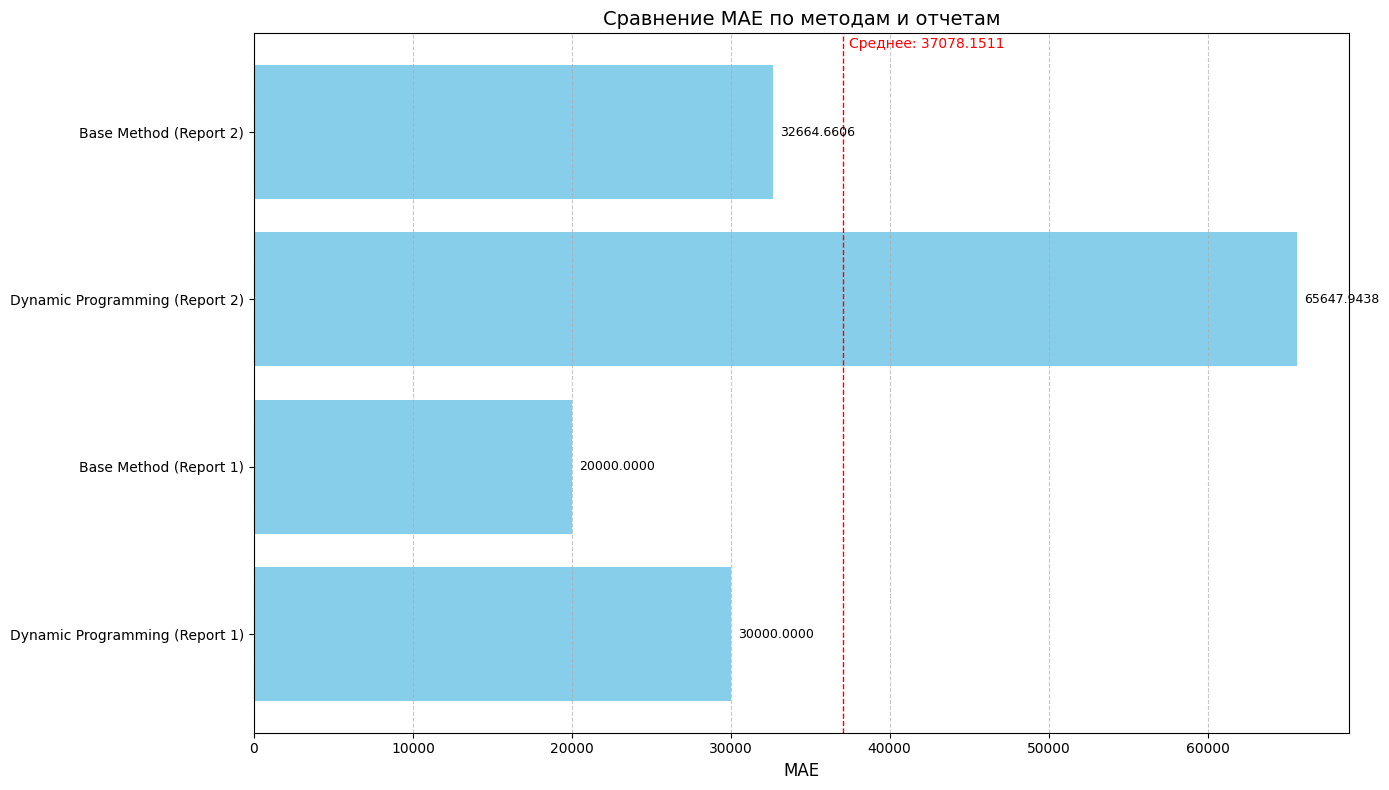

metric = mse


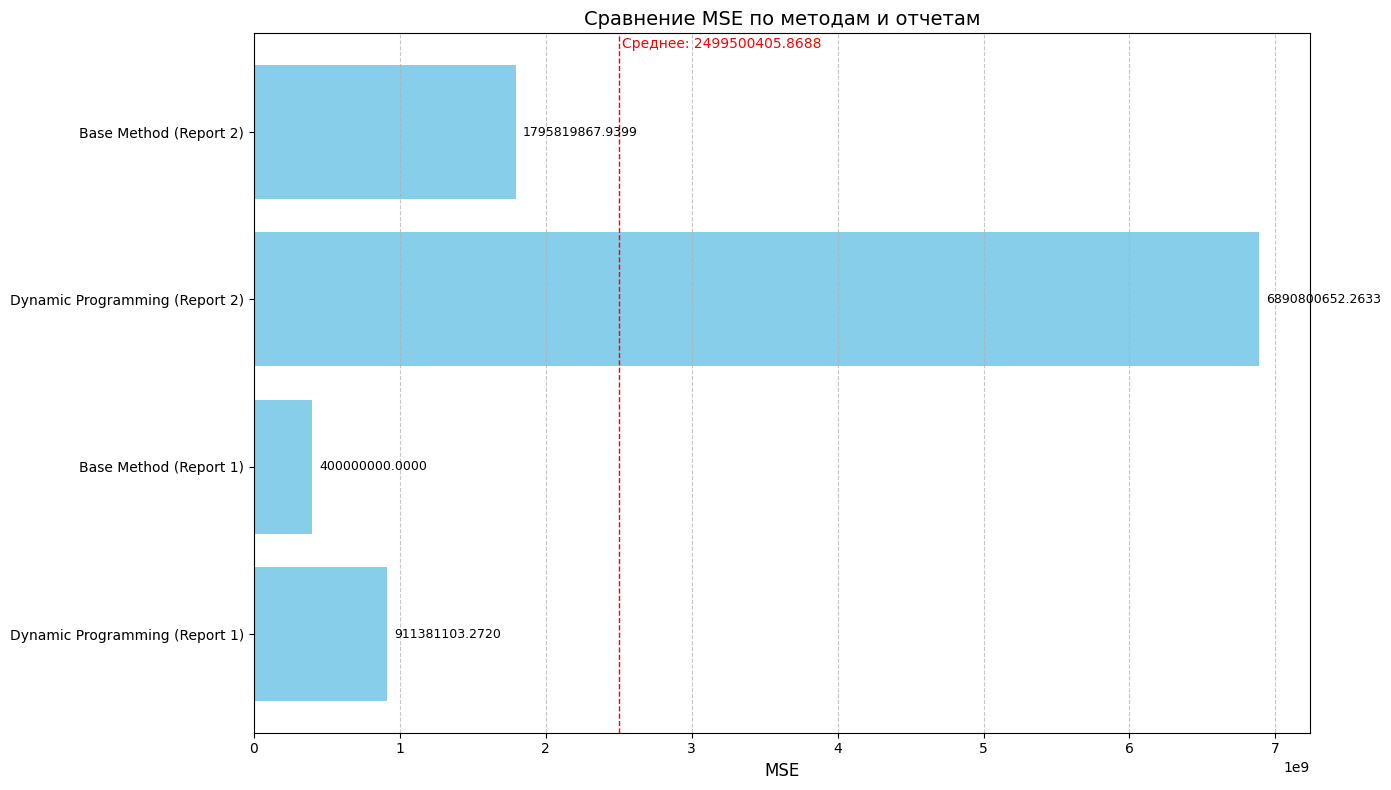

metric = rmse


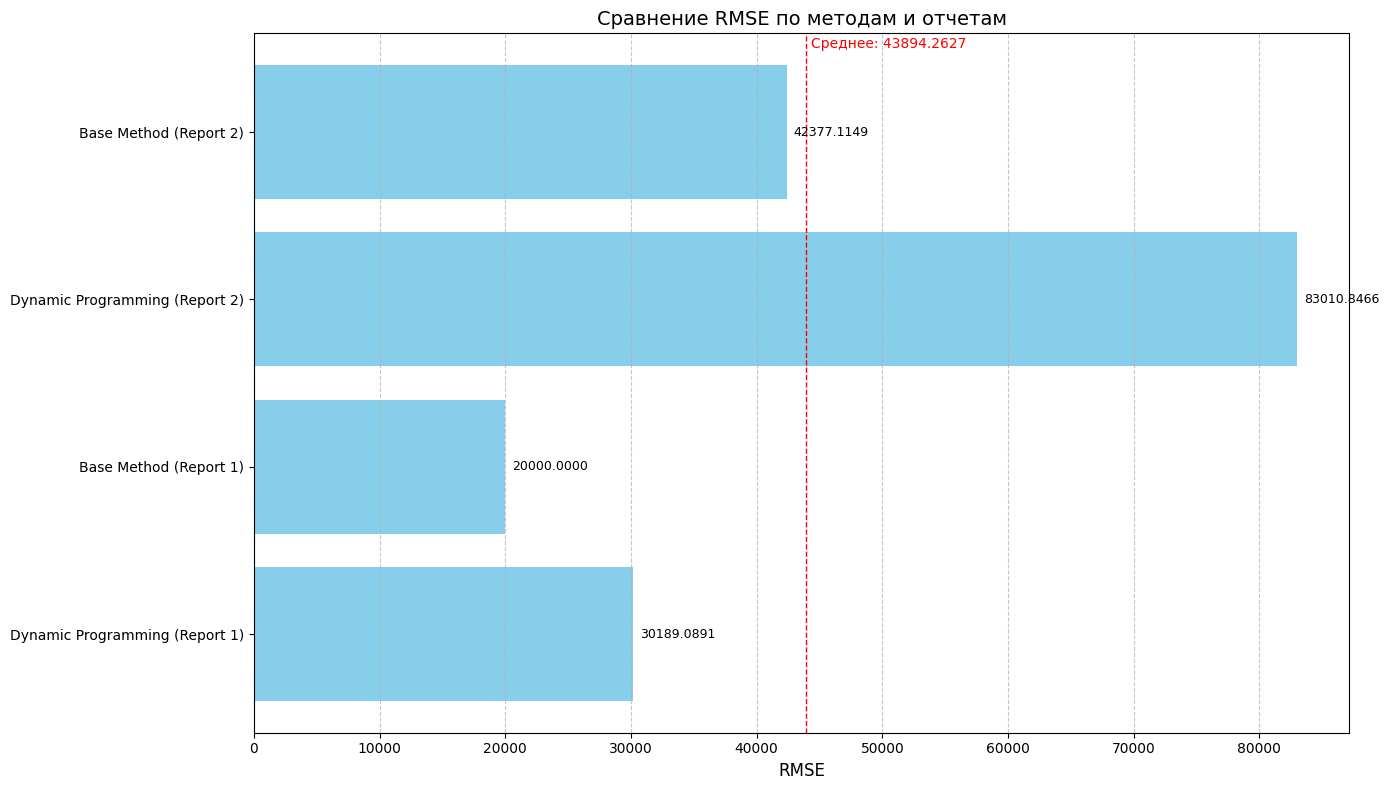

metric = r2


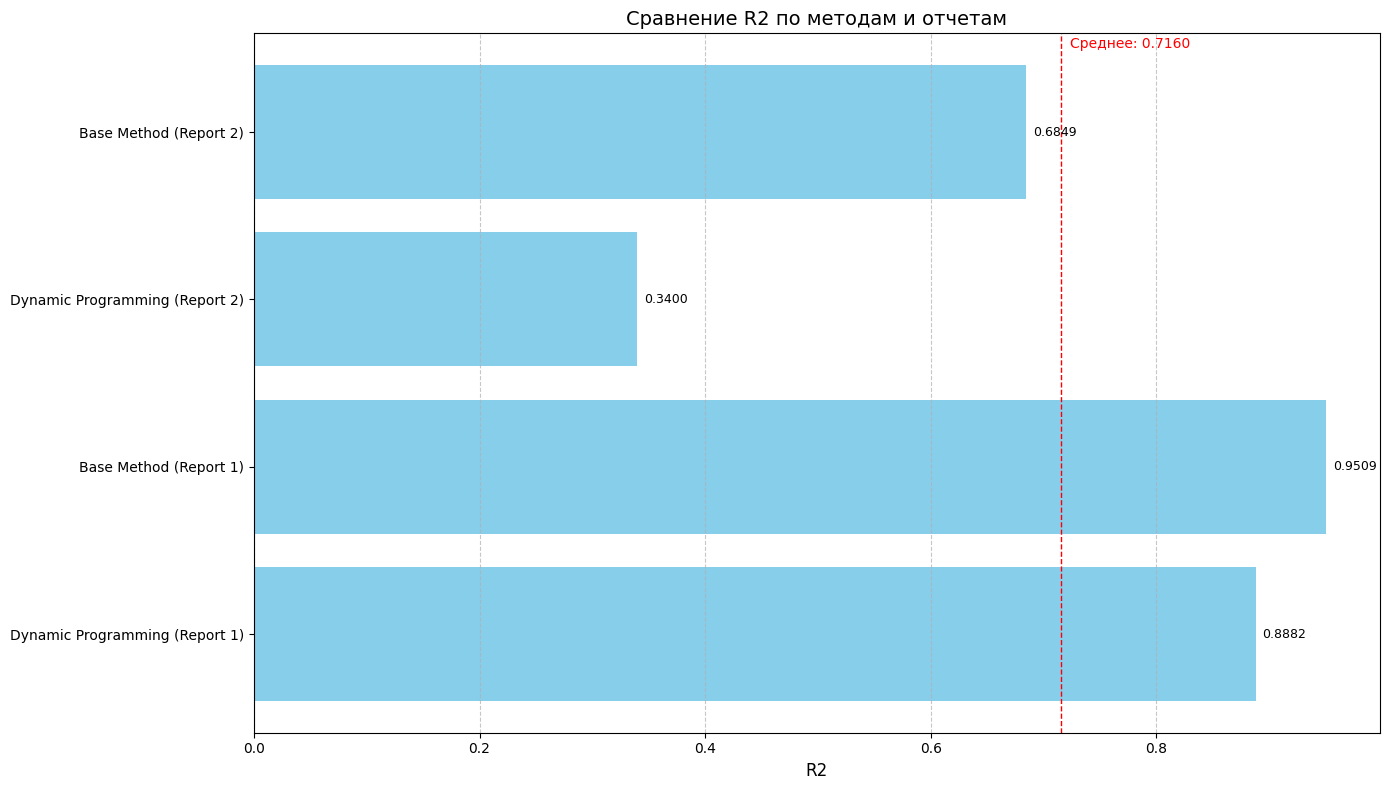

In [35]:
for metric, data in comparison_report.items():
    print(f'metric = {metric}')
    plot_metric_comparison(metric, data)